In [1]:
from utils import *

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from xgboost import XGBRegressor, DMatrix, cv
from xgboost import train as train_xgb

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])
tverskoe_issue_fix(train_df)
tverskoe_issue_fix(test_df)

Fix:  550
Fix:  149


## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
train_df['is_train'] = 1
test_df['is_train'] = 0

coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_df['latitude']
all_df['longitude'] = coords_df['longitude']

## 3. Removing outliers

In [7]:
all_df = remove_outliers(all_df)

## 4. Feature engineering

In [8]:
all_df = create_new_features(all_df)

## 5. Removing fake prices

In [9]:
train_df = remove_fake_prices(train_df)

REMOVED: 69


In [10]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

In [29]:
idx_outliers_old = np.loadtxt('data/outliers/idx_outliers_old.txt').astype(int)
len(idx_outliers_old)

2695

### `product_type == 'Investment'`

#### FIRST

In [14]:
train_df_0 = train_df[train_df['product_type'] == 0]

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])

In [15]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'booster': 'gbtree',
          'tree_method': 'gpu_hist',
          'n_estimators': 10000,
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.23057	validation_1-rmse:8.23480
[1]	validation_0-rmse:7.82175	validation_1-rmse:7.82591
[2]	validation_0-rmse:7.43349	validation_1-rmse:7.43756
[3]	validation_0-rmse:7.06475	validation_1-rmse:7.06879
[4]	validation_0-rmse:6.71457	validation_1-rmse:6.71862
[5]	validation_0-rmse:6.38202	validation_1-rmse:6.38603
[6]	validation_0-rmse:6.06624	validation_1-rmse:6.07020
[7]	validation_0-rmse:5.76639	validation_1-rmse:5.77031
[8]	validation_0-rmse:5.48168	validation_1-rmse:5.48559
[9]	validation_0-rmse:5.21138	validation_1-rmse:5.21529
[10]	validation_0-rmse:4.95475	validation_1-rmse:4.95864
[11]	validation_0-rmse:4.71111	validation_1-rmse:4.71481
[12]	validation_0-rmse:4.47982	validation_1-rmse:4.48346
[13]	validation_0-rmse:4.26026	validation_1-rmse:4.26379
[14]	validation_0-rmse:4.05188	validation_1-rmse:4.05537
[15]	validation_0-rmse:3.85407	validation_1-rmse:3.85763
[16]	validation_0-rmse:3.66640	validation_1-rmse:3.66984
[17]	validation_0-rmse:3.48833	validation

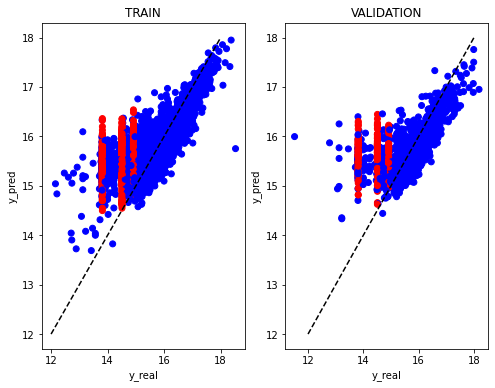

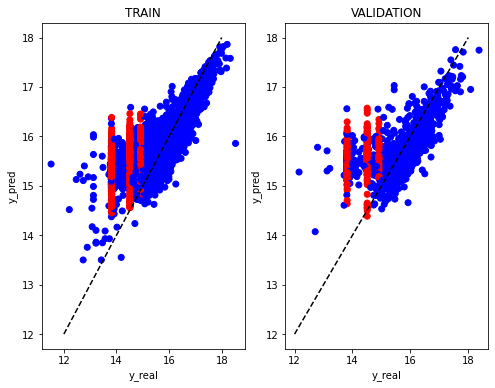

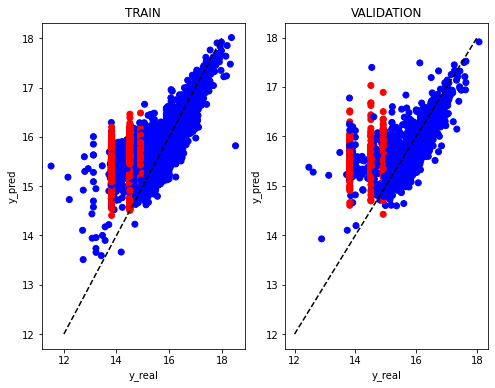

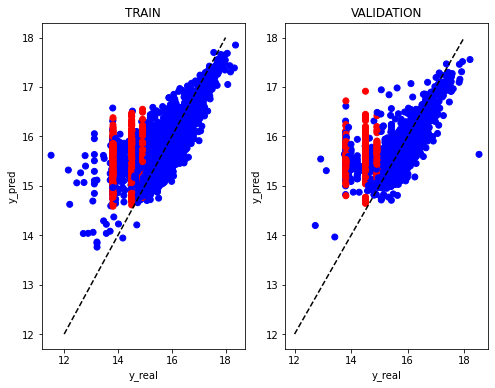

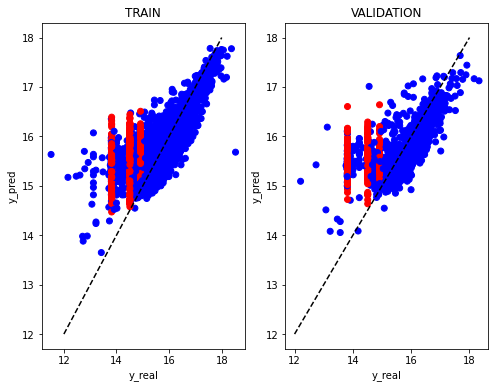

In [16]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

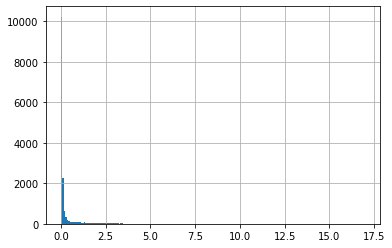

In [17]:
train_errors[4].hist(bins=200);

In [18]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 2.5].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 2.5].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)
idx_outliers.sort()

In [34]:
np.savetxt('data/outliers/idx_outliers_25.txt', idx_outliers, fmt='%d')
idx_outliers_25 = idx_outliers

In [35]:
set(idx_outliers_25).difference(set(idx_outliers_old))

set()

In [36]:
len(idx_outliers_25)

788

#### SECOND

In [37]:
train_df_0 = train_df[train_df['product_type'] == 0].drop(idx_outliers_25)

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])

In [38]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'booster': 'gbtree',
          'tree_method': 'gpu_hist',
          'n_estimators': 10000,
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.29332	validation_1-rmse:8.30052
[1]	validation_0-rmse:7.88058	validation_1-rmse:7.88809
[2]	validation_0-rmse:7.48853	validation_1-rmse:7.49614
[3]	validation_0-rmse:7.11616	validation_1-rmse:7.12392
[4]	validation_0-rmse:6.76248	validation_1-rmse:6.77028
[5]	validation_0-rmse:6.42655	validation_1-rmse:6.43445
[6]	validation_0-rmse:6.10751	validation_1-rmse:6.11546
[7]	validation_0-rmse:5.80450	validation_1-rmse:5.81239
[8]	validation_0-rmse:5.51673	validation_1-rmse:5.52466
[9]	validation_0-rmse:5.24347	validation_1-rmse:5.25143
[10]	validation_0-rmse:4.98393	validation_1-rmse:4.99196
[11]	validation_0-rmse:4.73744	validation_1-rmse:4.74551
[12]	validation_0-rmse:4.50340	validation_1-rmse:4.51147
[13]	validation_0-rmse:4.28117	validation_1-rmse:4.28922
[14]	validation_0-rmse:4.07012	validation_1-rmse:4.07805
[15]	validation_0-rmse:3.86974	validation_1-rmse:3.87759
[16]	validation_0-rmse:3.67952	validation_1-rmse:3.68736
[17]	validation_0-rmse:3.49889	validation

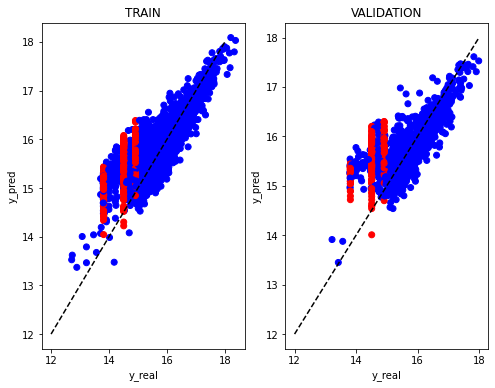

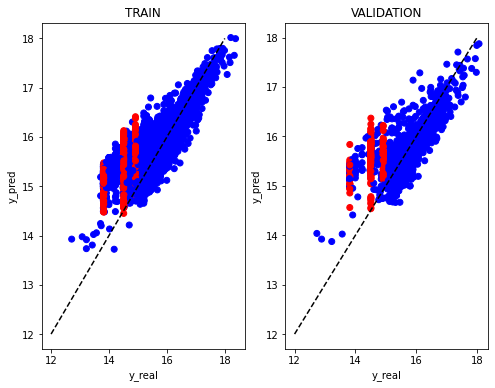

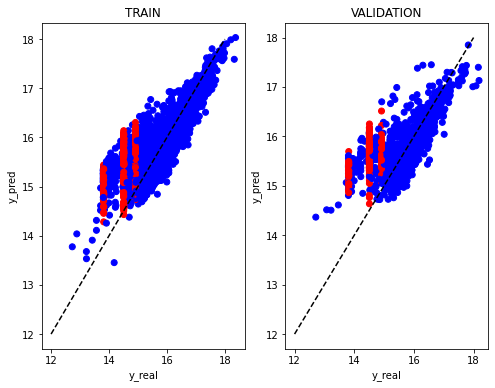

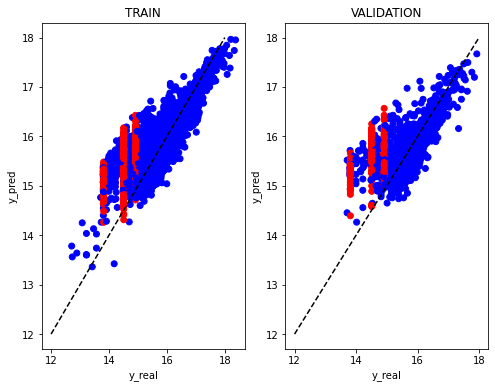

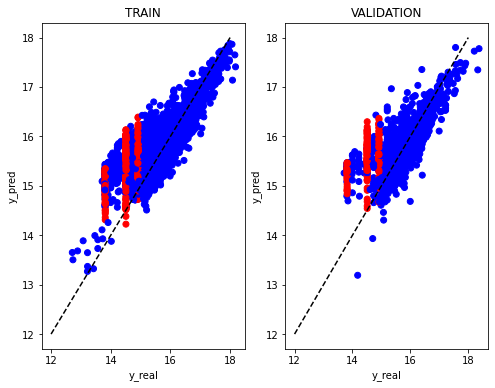

In [39]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

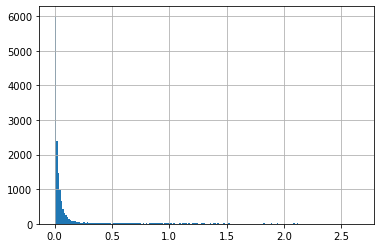

In [40]:
train_errors[4].hist(bins=200);

In [59]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 1.1].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 1.1].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)
idx_outliers.sort()

In [69]:
idx_outliers = np.append(idx_outliers, idx_outliers_25)

In [70]:
set(idx_outliers).difference(set(idx_outliers_old))

set()

In [76]:
np.savetxt('data/outliers/idx_outliers_25_11.txt', idx_outliers, fmt='%d')
idx_outliers_25_11 = idx_outliers

In [77]:
len(idx_outliers_25_11)

1848

#### THIRD

In [78]:
train_df_0 = train_df[train_df['product_type'] == 0].drop(idx_outliers_25_11)

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])

In [79]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'booster': 'gbtree',
          'tree_method': 'gpu_hist',
          'n_estimators': 10000,
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.36832	validation_1-rmse:8.36429
[1]	validation_0-rmse:7.95109	validation_1-rmse:7.94728
[2]	validation_0-rmse:7.55475	validation_1-rmse:7.55113
[3]	validation_0-rmse:7.17825	validation_1-rmse:7.17478
[4]	validation_0-rmse:6.82060	validation_1-rmse:6.81733
[5]	validation_0-rmse:6.48088	validation_1-rmse:6.47774
[6]	validation_0-rmse:6.15816	validation_1-rmse:6.15512
[7]	validation_0-rmse:5.85163	validation_1-rmse:5.84864
[8]	validation_0-rmse:5.56045	validation_1-rmse:5.55759
[9]	validation_0-rmse:5.28389	validation_1-rmse:5.28106
[10]	validation_0-rmse:5.02119	validation_1-rmse:5.01841
[11]	validation_0-rmse:4.77164	validation_1-rmse:4.76892
[12]	validation_0-rmse:4.53461	validation_1-rmse:4.53190
[13]	validation_0-rmse:4.30947	validation_1-rmse:4.30682
[14]	validation_0-rmse:4.09562	validation_1-rmse:4.09295
[15]	validation_0-rmse:3.89251	validation_1-rmse:3.88973
[16]	validation_0-rmse:3.69961	validation_1-rmse:3.69679
[17]	validation_0-rmse:3.51637	validation

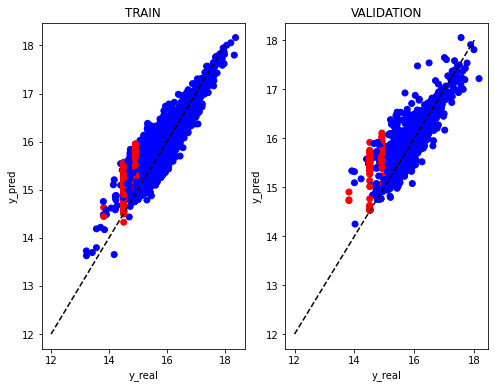

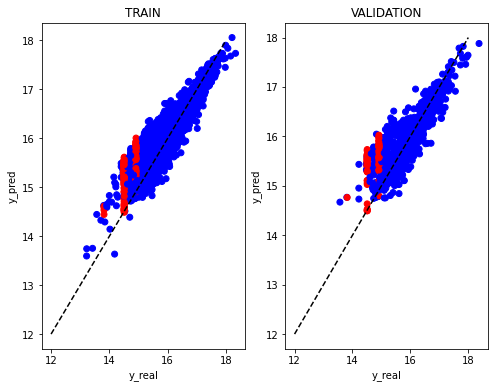

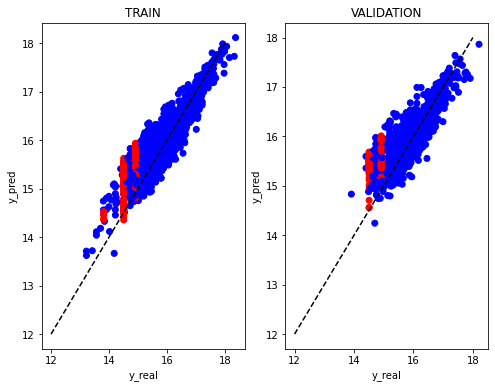

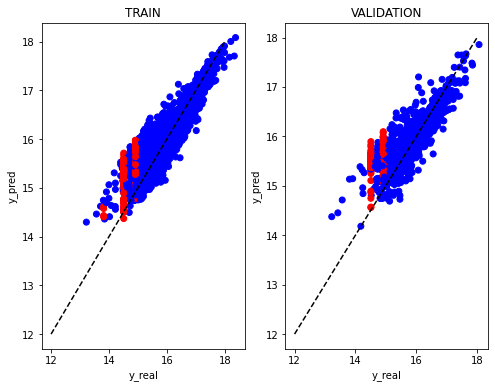

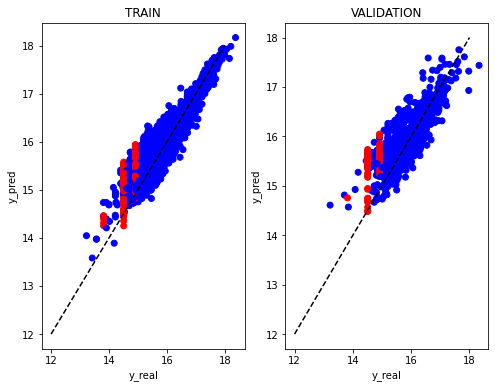

In [80]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

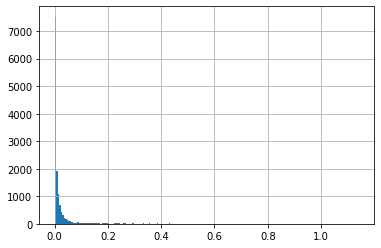

In [82]:
train_errors[4].hist(bins=200);

In [108]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 0.4].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 0.4].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)
idx_outliers.sort()

In [111]:
idx_outliers_25_11_04 = np.append(idx_outliers, idx_outliers_25_11)
idx_outliers_25_11_04.sort()

In [112]:
np.savetxt('data/outliers/idx_outliers_25_11.txt', idx_outliers_25_11_04, fmt='%d')

In [114]:
len(idx_outliers_25_11_04)

2674

In [100]:
len(idx_outliers_old)

2695

### `product_type == 'Investment'`

In [ ]:
X = train_df.drop(idx_outliers).copy()

In [ ]:
train_df_1 = X[X['product_type'] == 1]

X = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_1['price_doc'])

In [ ]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.14738	validation_1-rmse:8.15217
[1]	validation_0-rmse:7.74130	validation_1-rmse:7.74549
[2]	validation_0-rmse:7.35554	validation_1-rmse:7.35916
[3]	validation_0-rmse:6.98904	validation_1-rmse:6.99283
[4]	validation_0-rmse:6.64085	validation_1-rmse:6.64457
[5]	validation_0-rmse:6.31011	validation_1-rmse:6.31330
[6]	validation_0-rmse:5.99586	validation_1-rmse:5.99894
[7]	validation_0-rmse:5.69735	validation_1-rmse:5.70054
[8]	validation_0-rmse:5.41373	validation_1-rmse:5.41692
[9]	validation_0-rmse:5.14430	validation_1-rmse:5.14735
[10]	validation_0-rmse:4.88835	validation_1-rmse:4.89140
[11]	validation_0-rmse:4.64517	validation_1-rmse:4.64783
[12]	validation_0-rmse:4.41419	validation_1-rmse:4.41683
[13]	validation_0-rmse:4.19473	validation_1-rmse:4.19704
[14]	validation_0-rmse:3.98626	validation_1-rmse:3.98834
[15]	validation_0-rmse:3.78822	validation_1-rmse:3.79004
[16]	validation_0-rmse:3.60006	validation_1-rmse:3.60174
[17]	validation_0-rmse:3.42133	validation

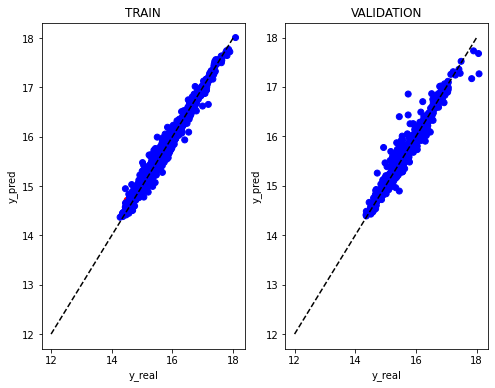

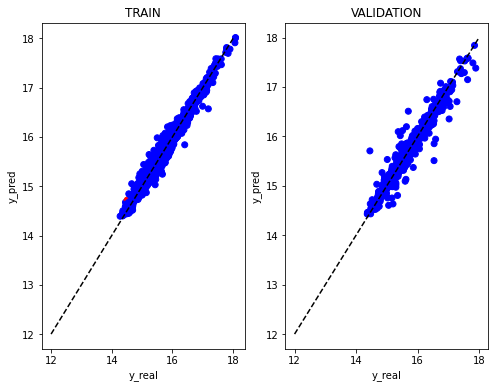

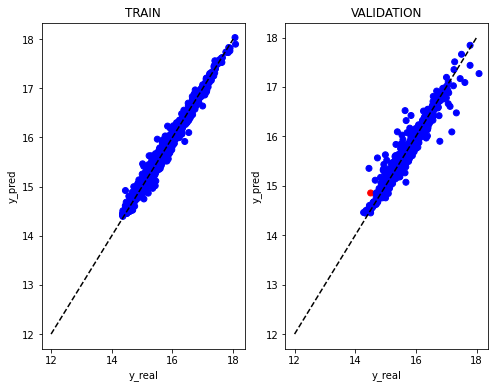

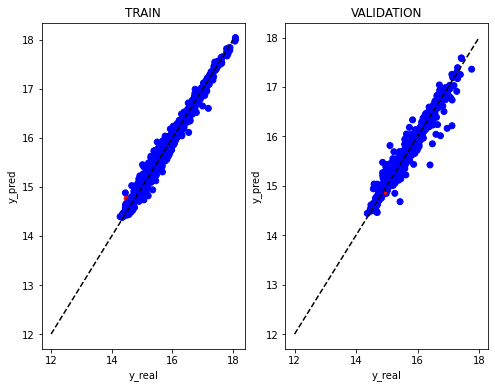

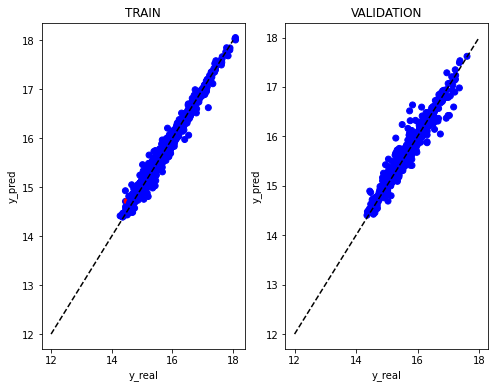

In [ ]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

In [ ]:
np.savetxt('data/idx_outliers.txt', idx_outliers_full, fmt='%d')

### `product_type == 'OwnerOccupier'`

In [ ]:
train_df_1 = train_df[train_df['product_type'] == 1]
test_df_1 = test_df[test_df['product_type'] == 1]

X_1 = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y_1 = np.log1p(train_df_1['price_doc'])
X_test_1 = test_df_1.drop(['sub_area'], axis=1).copy()

In [ ]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X_1)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X_1.iloc[train_index], X_1.iloc[val_index]
    y_train, y_val = y_1.iloc[train_index], y_1.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

In [ ]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X_1)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y_1.iloc[train_index], y_1.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

In [ ]:
train_errors[0].hist(bins=200)